In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import struct

def nrnMread(fileName):
    f = open(fileName, "rb")
    nparam = struct.unpack('i', f.read(4))[0]
    typeFlg = struct.unpack('i', f.read(4))[0]
    return np.fromfile(f,np.double)

data_dir ='../Data'

# for i in range(4,7): #Nstims
#     curr_volts = nrnMread(data_dir + '/VHotP' + str(i)  + '.dat')
#     curr_times = np.genfromtxt(data_dir + '/times' + str(i) + '.csv', delimiter =',')
#     Nt = int(len(curr_volts)/len(curr_times))
#     shaped_volts = np.reshape(curr_volts, [len(curr_times), Nt])
#     print(shaped_volts.shape)
#     times = shaped_volts.shape[0]
    
#     for indv in range(0,5):
#         plt.figure()
#         plt.plot(np.arange(len(curr_times)),shaped_volts[:,indv])
#         plt.title("indv" + str(indv) + " shaped incorrectly")
#         plt.ylim(-70,70)

# #plt.ylim(bottom=ymin) #ymin is your value
# print("population len:" ,Nt)
# plt.show()

(777, 10000)
(777, 10000)
population len: 777


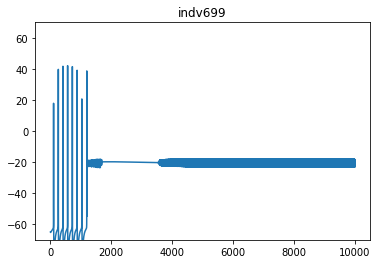

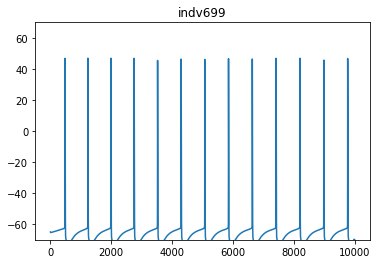

49.39570999145508


In [8]:
for i in range(0,2): #Nstims
    curr_volts = nrnMread(data_dir + '/VHotP' + str(i)  + '.dat')
    curr_times = np.genfromtxt(data_dir + '/times' + str(i) + '.csv', delimiter =',')
    Nt = int(len(curr_volts)/len(curr_times))
    shaped_volts = np.reshape(curr_volts, [Nt,len(curr_times)])
    print(shaped_volts.shape)
    times = shaped_volts.shape[0]
    
    for indv in range(699,700):
        plt.figure()
        plt.plot(np.arange(len(curr_times)),shaped_volts[indv,:])
        plt.title("indv" + str(indv))
        plt.ylim(-70,70)

#plt.ylim(bottom=ymin) #ymin is your value
print("population len:" ,Nt)
plt.show()
print(np.max(shaped_volts))

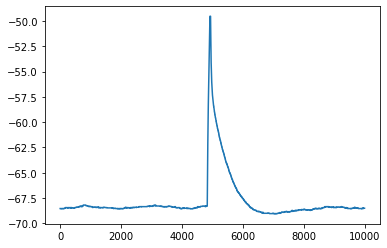

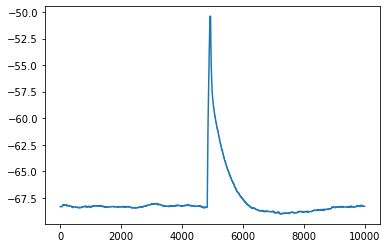

In [6]:
import h5py

run_volts_path = '../run_volts_bbp_full_gpu_tuned/'
paramsCSV = run_volts_path+'params/params_bbp_full_gpu_tuned_10_based.csv'
orig_params = h5py.File(run_volts_path+'params/params_bbp_full_allen_gpu_tune.hdf5', 'r')['orig_full'][0]
scores_path = '../scores/'
objectives_file = h5py.File('../python/objectives/multi_stim_bbp_full_allen_gpu_tune_18_stims.hdf5', 'r')
opt_weight_list = objectives_file['opt_weight_list'][:]
opt_stim_name_list = objectives_file['opt_stim_name_list'][:]
score_function_ordered_list = objectives_file['ordered_score_function_list'][:]
stims_path = run_volts_path+'/stims/allen_data_stims_10000.hdf5'
target_volts_path = '../python/target_volts/allen_data_target_volts_10000.hdf5'
target_volts_hdf5 = h5py.File(target_volts_path, 'r')
opt_stim_list = [e.decode('ascii') for e in opt_stim_name_list]
target_volts_list = np.array([target_volts_hdf5[s][:] for s in opt_stim_name_list])

for i in range(16,18):
    plt.figure()
    plt.plot(target_volts_list[i,:])

In [3]:
for i in range(1000):
    if max(shaped_volts[i,:]) > 20:
        print(i)

4
6
8
19
22
24
31
36
38
42
43
44
47
53
55
56
65
68
69
80
87
93
94
97
100
103
115
123
125
136
137
142
149
155
158
161
166
172
174
181
182
185
192
195
197
204
207
215
217
219
225
226
231
235
249
251
254
257
258
261
265
267
269
271
276
278
286
295
297
304
315
319
330
331
343
350
355
358
359
363
368
373
376
379
381
385
393
396
400
402
404
406
416
418
420
422
434
436
441
445
447
449
451
456
460
461
464
466
468
469
471
474
475
476
479
483
489
491
492
498
501
512
513
514
515
517
524
527
531
532
534
542
547
548
555
556
559
560
563
565
566
567
573
576
586
593
605
608
611
613
620
621
627
641
645
649
651
655
665
667
668
669
671
674
680
681
682
684
687
690
692
694
695
705
708
715
717
721
724
726
727
728
731
741
743
747
751
752
754
757
761
764
769
773
774
776
781
785
794


IndexError: index 795 is out of bounds for axis 0 with size 795

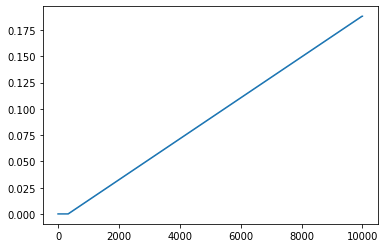

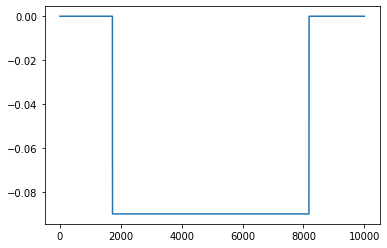

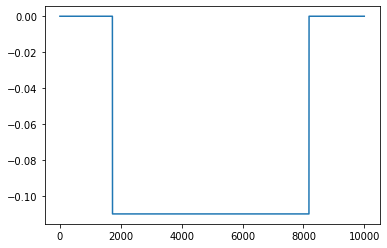

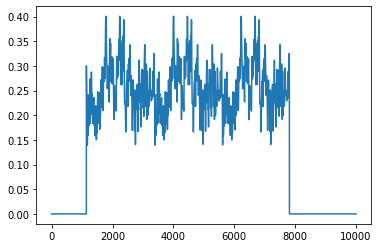

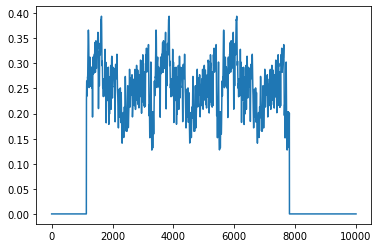

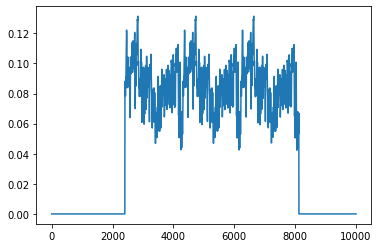

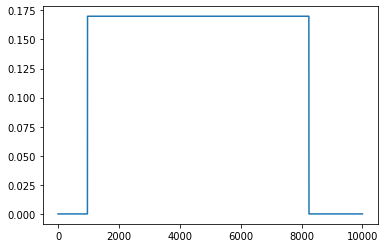

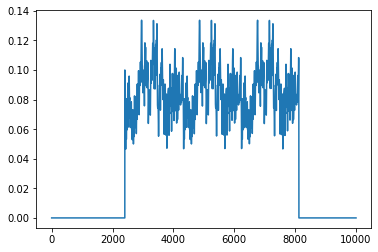

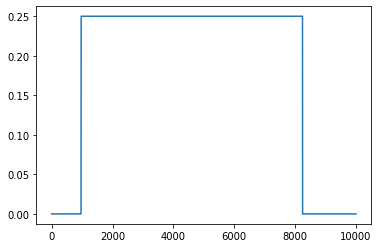

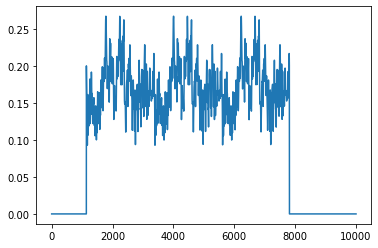

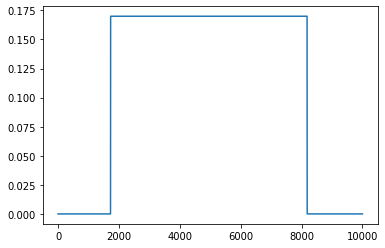

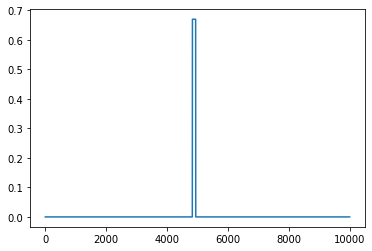

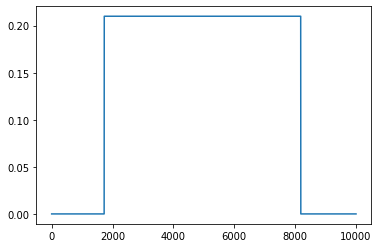

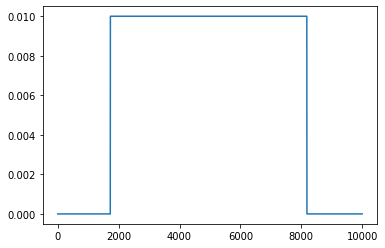

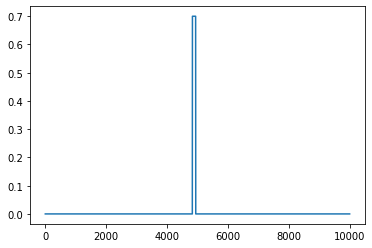

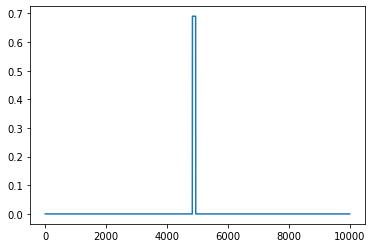

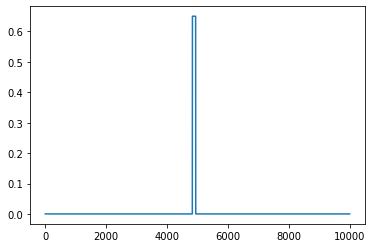

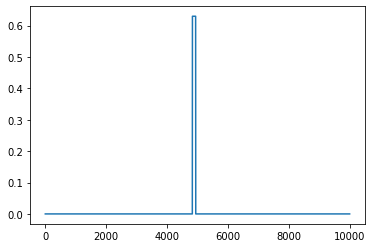

In [13]:
import h5py
objectives_file = h5py.File('../python/objectives/multi_stim_bbp_full_allen_gpu_tune_18_stims.hdf5', 'r')

allen_stim_file = h5py.File('../run_volts_bbp_full_gpu_tuned/stims/allen_data_stims_10000.hdf5', 'r')
opt_stim_name_list = objectives_file['opt_stim_name_list'][:]
stims = list([e.decode('ascii') for e in opt_stim_name_list])[:]
score_function_ordered_list = objectives_file['ordered_score_function_list'][:]
for stim in stims:
    plt.figure()
    plt.plot(allen_stim_file[stim][:])